- - - -
# Analyze Fluorescent Lifetimes from TCSPC Data

- - - -

Troy Messina @ Berea College

- - - -

**1) Load Time-Correlated Single Photon (TCSPC) from Excel**    
**2) Plot Data**  
**3) Curve Fitting**  

- - - -

This is a tutorial to work with data collected from the Becker and Hickl photon counting experiment to measure fluoresent lifetimes. We're using acrylodan-beta-mercaptoethanol adduct in water-isopropanol binary solvents.

In [5]:
# import modules
import pandas as pd
import numpy as np
from numpy import array, arange, pi, exp, sin, cos, polyfit, poly1d, linspace, zeros, flipud
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import fmin
from scipy.ndimage import shift
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

## Preparing and loading the data from Excel
We're going to use pandas to load the data. I have prepared an Excel file that has a sheet containing all of the data, including the x-values of time in nanoseconds. The time is obtained by recording the $dt$ from the Becker-Hickl software. Typically, we have a 25 nanosecond time window (TAC) that is divided into 4095 bins. So, each bin is 0.00605 ns. In Excel, I put all of the data into one sheet called "all_data_trim". In this sheet, I trimmed ends of the data where the digitization and dithering caused weird things to happen. I've also set the instrument response to zero where it is background. The way to do this in Excel is by using the equation ```=if(B3>35, B3, 0)```. In this case I have the instrument response in column B3. The background is 35 photons. You will need to adjust this for your particular instrument response. Finally, I normalized the instrument response function (IRF) so that it is a probability distribution (sums to 1). Do this by finding the sum of the instrument response data and divide it by this number.

Upload your data to Azure using the Data menu. Make sure the data goes to your ~/library folder so that it is perpetual. Copy the file path after it uploads so you can paste it in the next step.

In [2]:
#We'll use pandas to load an Excel file. Pandas is very smart at this.
all_data_df = pd.read_excel('/home/nbuser/library/LifetimeData.xlsx', 'all_data_trim', index_col=None, na_values=['NA'])

Next, we'll convert the data into numpy arrays so we can easily plot and analyze it. The ```all_data_df``` and ```alldatamatrix``` will be arranged according to your Excel spreadsheet. So, be careful about the array indices. They need to match how you set up your Excel sheet.

In [3]:
alldatamatrix = all_data_df.values
time_ns = np.array(alldatamatrix[:,0], dtype=np.float64)
IRF1 = np.array(alldatamatrix[:,1], dtype=np.float64)
#IRF2 = np.array(alldatamatrix[:,2], dtype=np.float64)#This data appears to be the same as IRF1. I'm commenting it out.
water000 = np.array(alldatamatrix[:,3], dtype=np.float64)
water010 = np.array(alldatamatrix[:,4], dtype=np.float64)
water020 = np.array(alldatamatrix[:,5], dtype=np.float64)
water030 = np.array(alldatamatrix[:,6], dtype=np.float64)
water040 = np.array(alldatamatrix[:,7], dtype=np.float64)
water050 = np.array(alldatamatrix[:,8], dtype=np.float64)
water060 = np.array(alldatamatrix[:,9], dtype=np.float64)
water070 = np.array(alldatamatrix[:,10], dtype=np.float64)
water080 = np.array(alldatamatrix[:,11], dtype=np.float64)
water090 = np.array(alldatamatrix[:,12], dtype=np.float64)
water100 = np.array(alldatamatrix[:,13], dtype=np.float64)

Let's plot some of it to make sure everything came through correctly.

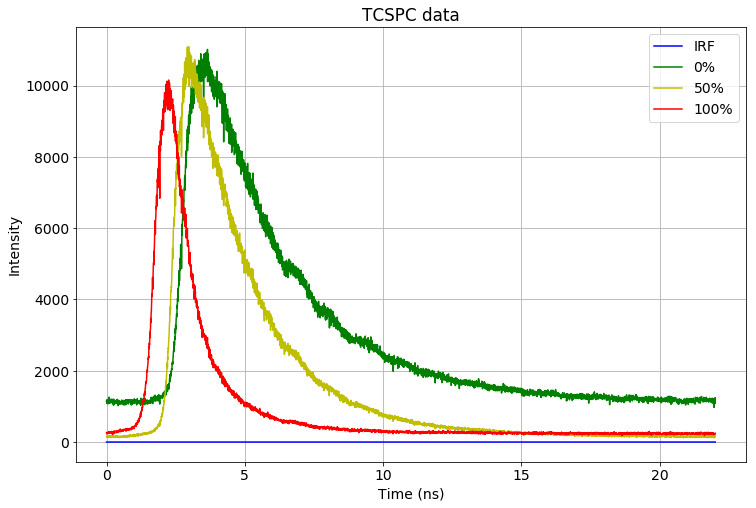

In [6]:
plt.plot(time_ns, IRF1, 'b',label='IRF')
plt.plot(time_ns, water000, 'g', label='0%')
plt.plot(time_ns, water050, 'y', label='50%')
plt.plot(time_ns, water100, 'r', label='100%')
plt.xlabel('Time (ns)')
plt.ylabel('Intensity')
#plt.yscale('log')
plt.title('TCSPC data')
plt.legend(loc=1) #loc 1 is upper right, loc 2 is upper left, loc 3 is lower left, loc 4 is lower right
#plt.axis([0, 2.8, 0, 0.001])
plt.grid(True)
plt.show()

Because the IRF is normalized, it's difficult to see. It's vertical scale is thousands of times smaller. Let's plot it by itself.

[0. 0. 0. ... 0. 0. 0.]


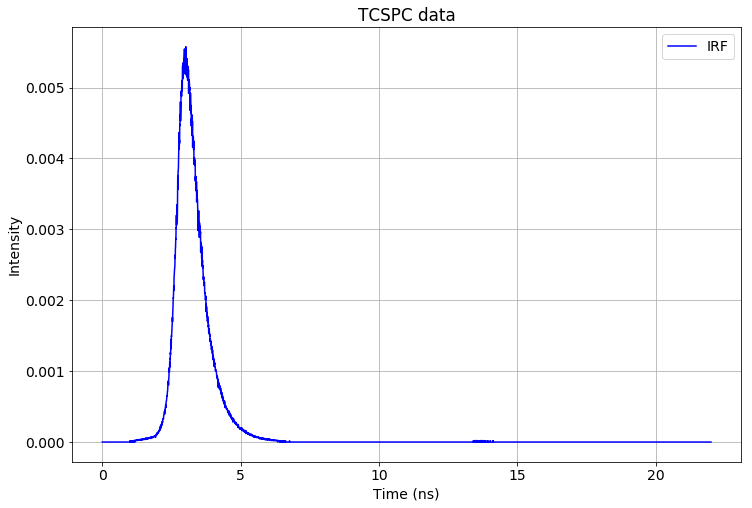

In [7]:
plt.plot(time_ns, IRF1, 'b',label='IRF')
plt.xlabel('Time (ns)')
plt.ylabel('Intensity')
#plt.yscale('log')
plt.title('TCSPC data')
plt.legend(loc=1) #loc 1 is upper right, loc 2 is upper left, loc 3 is lower left, loc 4 is lower right
#plt.axis([0, 2.8, 0, 0.001])
plt.grid(True)
plt.show()

The lifetime data is a convolution of the instrument response (IRF) and an exponentially decaying function. The instrument response comes from scattering of the light due to the laser pulse. The exponential comes from the decay of the excited fluorescent molecule. Each acrylodan molecule has a probability of de-exciting and emitting a photon that is exponentially decreasing over time. This comes from the fact that there is a concentration of excited molecules $[S_1]$. There is a decay rate (number of de-excitations per second) $k$. If I multiply the decay rate times the concentration of excited molecules, I get the decaying concentration rate. $d[S_1]/dt$.

$$\frac{d\left[S_1\right]}{dt} = -k \left[S_1\right]$$

The minus sign indicates that the change is a reduction in concentration. I can move things around to get

$$\frac{d\left[S_1\right]}{\left[S_1\right]} = -k dt$$

Integrating both sides, I get

$$\ln\left(\left[S_1\right]\right) = -k t$$

I can exponentiate both sides to get

$$\left[S_1\right] = e^{-kt}$$

which tells me the concentration of excited molecules drops exponentially over time. The intensity of fluorescent light is directly related to the conentration of excited molecules. If there are multiple decay rates, the intensity we measure becomes a sum of the decays

$$I\left(t\right) = I_1e^{-k_1t} + I_2e^{-k_2t} +I_3e^{-k_3t} = \sum_i I_ie^{-k_it}$$

Let's see if we can convolve an exponential function with the instrument response and make it look like the data. If we can do that, we should be able to do a curve fit to optimize the exponential. There are several steps involved besides just the convolution.
1. We need to define a decay rate $k$ or lifetime $\tau = 1/k$.
2. We need to define an exponential function that is point-by-point aligned with the data and IRF.
3. We need to shift the instrument response left or right to align with the data.
4. We need to convolve the exponential function with the instrument response function.
5. We need to cut the convolution because it will be twice the length of the exponential and IRF.
6. We need to amplify the convolution so that it is as high along the y-axis as the data.
7. We need to add an upward shift of the data because the detector has a uniformly distributed background.

Try adjusting all of these parameters below to get the convolution to match your data.

(3638,) (3638,)
[1100.         1100.         1100.         ... 1118.94879768 1118.90871605
 1118.86871921]


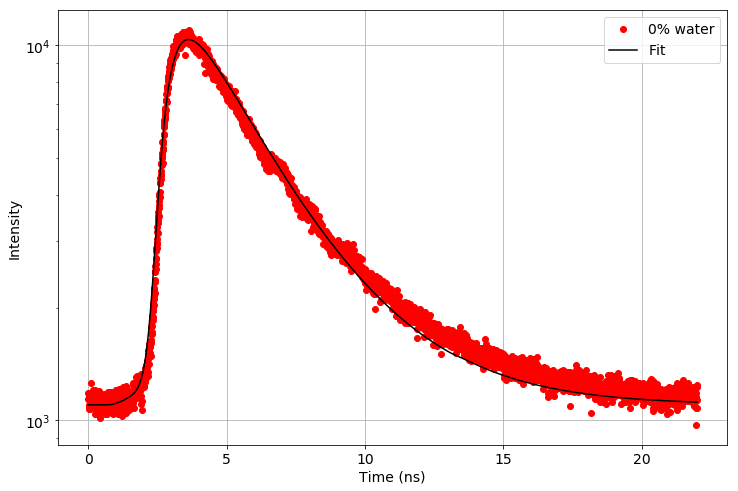

In [8]:
decay_rate = 0 # step 1.
Exponential = np.exp(-decay_rate*time_ns) # step 2.
scipy.ndimage.shift(IRF1, 0, output=IRF_temp, mode='wrap') # step 3.
ConvolveFunc=np.convolve(Exponential, IRF_temp, mode='full') # step 4.

length = len(time_ns)
ConvolveFunc = ConvolveFunc[0:length,] # step 5.
print(ConvolveFunc.shape, time_ns.shape) #Check the array shapes for match
ConvolveFunc *= 0 # step 6.
ConvolveFunc += 0 # step 7.

plt.plot(time_ns, water000, 'ro', label='0% water')
plt.plot(time_ns, ConvolveFunc, 'k', label='Fit')
plt.xlabel('Time (ns)')
plt.ylabel('Intensity')
#plt.title('TCSPC data')
plt.legend(loc=1) #loc 1 is upper right, loc 2 is upper left, loc 3 is lower left, loc 4 is lower right
plt.yscale('log')
plt.grid(True)
plt.show()

You should be convinced you have all the ingredients for doing a curve fit, i.e., you can get the convolution "Fit" close to your data. We'll use SciPy do the curve fitting. Because photon counting is a random process, we know that the uncertainty in any photon count is $\sqrt{\# Photons + 1}$. We will use this in the curve fitting so that the resulting fit parameters have standard errors in the covariant matrix.

The code below switches to a lifetime $\tau$ instead of rate $k = 1/\tau$. You will need to insert your guess from above into the fit parameters. We are also switching to a two-lifetime model to get a better fit to the data. I have left an initial guess for these parameters in the code.

values of the fitting parameters
lifetime 1 = 0.451 +/- 0.008  ns
lifetime 2 = 3.248 +/- 0.006  ns
[-3.21214242e+01  9.03996978e+03  4.50772904e-01  1.10310927e+04
  3.24761733e+00  1.12121665e+03]
[[ 0.0000e+00  2.9000e+01 -0.0000e+00  2.0000e+00 -0.0000e+00  0.0000e+00]
 [ 2.9000e+01  1.7371e+04 -1.0000e+00  9.7500e+02 -0.0000e+00  2.9000e+01]
 [-0.0000e+00 -1.0000e+00  0.0000e+00 -0.0000e+00  0.0000e+00 -0.0000e+00]
 [ 2.0000e+00  9.7500e+02 -0.0000e+00  6.1800e+02 -0.0000e+00  1.4000e+01]
 [-0.0000e+00 -0.0000e+00  0.0000e+00 -0.0000e+00  0.0000e+00 -0.0000e+00]
 [ 0.0000e+00  2.9000e+01 -0.0000e+00  1.4000e+01 -0.0000e+00  1.0000e+00]]


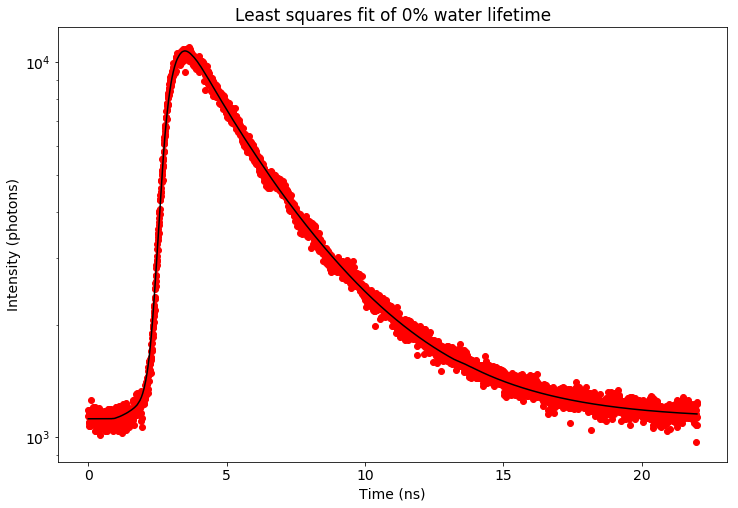

In [9]:
# non-linear least squares
#Define a function for optimizing the fit parameters.
#These are the 7 steps from above.
def fit_TCSPC(x, a, b1, c1, b2, c2, d):
    Exponential = b1*np.exp(-x/c1) + b2*np.exp(-x/c2)
    #IRF_temp = shift(IRF1, a) #np.roll shifts an array left (-) or right (+) to get the response aligned with the data
    scipy.ndimage.shift(IRF1, a, output=IRF_temp, mode='wrap')
    ConvolveFunc = np.convolve(Exponential, IRF_temp, mode='full') #Do the convolution
    ConvolveFunc = ConvolveFunc[0:length,] #Cut the convolution because it's twice the length of the original arrays
    #ConvolveFunc *= b # We need to amplify it to have the correct amplitude
    ConvolveFunc += d # We need to shift the whole thing upward because of background noise
    return ConvolveFunc

#Insert your values from above where you guess at the parameters.
a = 0 #initial guess roll value
b1 = 5000 #initial guess amplitude 1
c1 = 0.5 #initial guess decay rate 1
b2 = 0 #initial guess amplitude 2
c2 = 0 #initial guess decay rate 2
d = 0 #initial guess baseline
fit_guess = np.array([a, b1, c1, b2, c2, d])
xx = linspace(0, 22, length)
weights000 = np.sqrt(water000+1)
water000_params, water000_pcov = curve_fit(fit_TCSPC, time_ns, water000, p0=[a, b1, c1, b2, c2, d], sigma=weights000,absolute_sigma=True)

print('values of the fitting parameters')
print('lifetime 1 =', "{0:.3f}".format(water000_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water000_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water000_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water000_pcov[4,4])),' ns')
print(water000_params)
print(np.around(np.sqrt(np.abs(water000_pcov)), decimals=1))
#print(np.around(water000_pcov))#,decimals=3))
#print(water000_pcov)

plt.plot(time_ns, water000, 'ro')
plt.plot(xx, fit_TCSPC(xx, water000_params[0],water000_params[1], water000_params[2],water000_params[3],water000_params[4],water000_params[5]), 'k')
plt.title(r'Least squares fit of 0% water lifetime')
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (photons)')
plt.yscale('log')
plt.show()

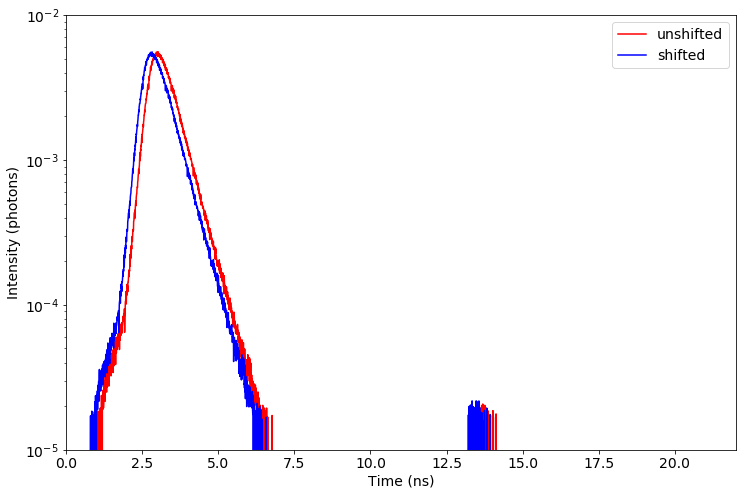

In [10]:
#Just a check of the IRF shifting
plt.plot(time_ns, IRF1, 'r', label='unshifted')
plt.plot(time_ns, IRF_temp, 'b',label='shifted')
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (photons)')
plt.yscale('log')
plt.legend(loc=1)
plt.axis([0, 22, 0.00001, 0.01])
plt.show()

We're ready to fit everything from 10% to 100% water (90% isopropanol to 0% isopropanol).

In [11]:
#Reprint the lifetimes for 0% water
print('0% water')
print('lifetime 1 =', "{0:.3f}".format(water000_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water000_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water000_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water000_pcov[4,4])),' ns')

#10% water
weights010 = np.sqrt(water010)+1
water010_params, water010_pcov = curve_fit(fit_TCSPC, time_ns, water010, p0=[a, b1, c1, b2, c2, d], sigma=weights010,absolute_sigma=True)

print('10% water')
print('lifetime 1 =', "{0:.3f}".format(water010_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water010_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water010_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water010_pcov[4,4])),' ns')

#20% water
weights020 = np.sqrt(water020)+1
water020_params, water020_pcov = curve_fit(fit_TCSPC, time_ns, water020, p0=[a, b1, c1, b2, c2, d], sigma=weights020,absolute_sigma=True)

print('20% water')
print('lifetime 1 =', "{0:.3f}".format(water020_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water020_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water020_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water020_pcov[4,4])),' ns')

#30% water
weights030 = np.sqrt(water030)+1
water030_params, water030_pcov = curve_fit(fit_TCSPC, time_ns, water030, p0=[a, b1, c1, b2, c2, d], sigma=weights030,absolute_sigma=True)

print('30% water')
print('lifetime 1 =', "{0:.3f}".format(water030_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water030_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water030_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water030_pcov[4,4])),' ns')

#40% water
weights040 = np.sqrt(water040)+1
water040_params, water040_pcov = curve_fit(fit_TCSPC, time_ns, water040, p0=[a, b1, c1, b2, c2, d], sigma=weights040,absolute_sigma=True)

print('40% water')
print('lifetime 1 =', "{0:.3f}".format(water040_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water040_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water040_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water040_pcov[4,4])),' ns')

#50% water
weights050 = np.sqrt(water050)+1
water050_params, water050_pcov = curve_fit(fit_TCSPC, time_ns, water050, p0=[a, b1, c1, b2, c2, d], sigma=weights050,absolute_sigma=True)

print('50% water')
print('lifetime 1 =', "{0:.3f}".format(water050_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water050_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water050_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water050_pcov[4,4])),' ns')

#60% water
weights060 = np.sqrt(water060)+1
water060_params, water060_pcov = curve_fit(fit_TCSPC, time_ns, water060, p0=[a, b1, c1, b2, c2, d], sigma=weights060,absolute_sigma=True)

print('60% water')
print('lifetime 1 =', "{0:.3f}".format(water060_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water060_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water060_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water060_pcov[4,4])),' ns')

#70% water
weights070 = np.sqrt(water070)+1
water070_params, water070_pcov = curve_fit(fit_TCSPC, time_ns, water070, p0=[a, b1, c1, b2, c2, d], sigma=weights070,absolute_sigma=True)

print('70% water')
print('lifetime 1 =', "{0:.3f}".format(water070_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water070_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water070_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water070_pcov[4,4])),' ns')

#80% water
weights080 = np.sqrt(water080)+1
water080_params, water080_pcov = curve_fit(fit_TCSPC, time_ns, water080, p0=[a, b1, c1, b2, c2, d], sigma=weights080,absolute_sigma=True)

print('80% water')
print('lifetime 1 =', "{0:.3f}".format(water080_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water080_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water080_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water080_pcov[4,4])),' ns')

#90% water
weights090 = np.sqrt(water090)+1
water090_params, water090_pcov = curve_fit(fit_TCSPC, time_ns, water090, p0=[a, b1, c1, b2, c2, d], sigma=weights090,absolute_sigma=True)

print('90% water')
print('lifetime 1 (90%) =', "{0:.3f}".format(water090_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water090_pcov[2,2])),' ns')
print('lifetime 2 (90%) =', "{0:.3f}".format(water090_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water090_pcov[4,4])),' ns')

#100% water
weights100 = np.sqrt(water100)+1
water100_params, water100_pcov = curve_fit(fit_TCSPC, time_ns, water100, p0=[a, b1, c1, b2, c2, d], sigma=weights100,absolute_sigma=True)

print('100% water')
print('lifetime 1 =', "{0:.3f}".format(water100_params[2,]), '+/-',  "{0:.3f}".format(np.sqrt(water100_pcov[2,2])),' ns')
print('lifetime 2 =', "{0:.3f}".format(water100_params[4,]), '+/-',  "{0:.3f}".format(np.sqrt(water100_pcov[4,4])),' ns')

0% water
lifetime 1 = 0.451 +/- 0.008  ns
lifetime 2 = 3.248 +/- 0.006  ns
10% water
lifetime 1 = 0.269 +/- 0.005  ns
lifetime 2 = 3.127 +/- 0.004  ns
20% water
lifetime 1 = 0.200 +/- 0.005  ns
lifetime 2 = 2.899 +/- 0.004  ns
30% water
lifetime 1 = 0.126 +/- 0.003  ns
lifetime 2 = 2.749 +/- 0.002  ns
40% water
lifetime 1 = 0.083 +/- 0.003  ns
lifetime 2 = 2.525 +/- 0.002  ns
50% water
lifetime 1 = 0.147 +/- 0.003  ns
lifetime 2 = 2.396 +/- 0.002  ns
60% water
lifetime 1 = 0.467 +/- 0.005  ns
lifetime 2 = 2.390 +/- 0.004  ns
70% water
lifetime 1 = 0.489 +/- 0.004  ns
lifetime 2 = 2.223 +/- 0.005  ns
80% water
lifetime 1 = 0.437 +/- 0.003  ns
lifetime 2 = 2.078 +/- 0.006  ns
90% water
lifetime 1 (90%) = 0.311 +/- 0.002  ns
lifetime 2 (90%) = 1.912 +/- 0.007  ns
100% water
lifetime 1 = 0.262 +/- 0.002  ns
lifetime 2 = 1.899 +/- 0.008  ns


Let's make arrays of the water concentrations and the fluorescent lifetimes and uncertainties from the covariant matrix. This will allow us to plot them.

In [42]:
water_percent=np.array([0,10,20,30,40,50,60,70,80,90,100])
lifetime1 = np.array([water000_params[2],water010_params[2],water020_params[2],water030_params[2],water040_params[2],water050_params[2],water060_params[2],water070_params[2],water080_params[2],water090_params[2],water100_params[2]])
lifetime1Err = np.array([water000_pcov[2,2],water010_pcov[2,2],water020_pcov[2,2],water030_pcov[2,2],water040_pcov[2,2],water050_pcov[2,2],water060_pcov[2,2],water070_pcov[2,2],water080_pcov[2,2],water090_pcov[2,2],water100_pcov[2,2]])
lifetime2 = np.array([water000_params[4],water010_params[4],water020_params[4],water030_params[4],water040_params[4],water050_params[4],water060_params[4],water070_params[4],water080_params[4],water090_params[4],water100_params[4]])
lifetime2Err = np.array([water000_pcov[4,4],water010_pcov[4,4],water020_pcov[4,4],water030_pcov[4,4],water040_pcov[4,4],water050_pcov[4,4],water060_pcov[4,4],water070_pcov[4,4],water080_pcov[4,4],water090_pcov[4,4],water100_pcov[4,4]])

Let's plot the fits to the lifetime data. Then, we'll plot the lifetime as a function of solvent concentration.

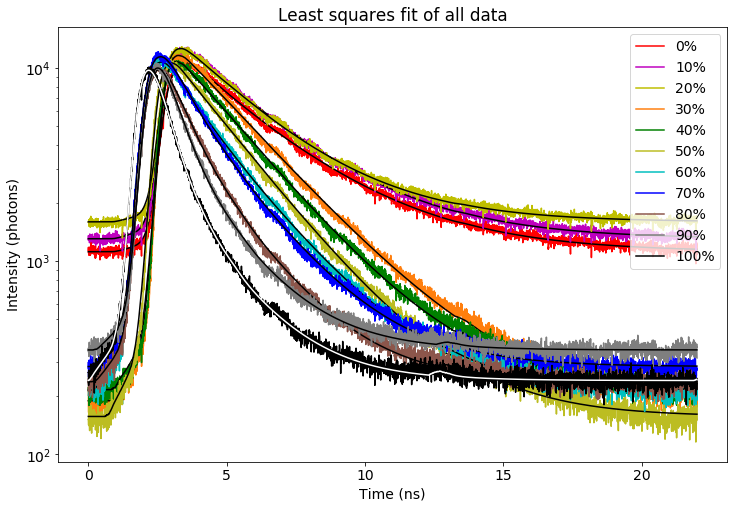

In [48]:
plt.plot(time_ns, water000, 'r', label='0%')
plt.plot(xx, fit_TCSPC(xx, water000_params[0],water000_params[1], water000_params[2],water000_params[3],water000_params[4],water000_params[5]), 'k')
plt.plot(time_ns, water010, 'm', label='10%')
plt.plot(xx, fit_TCSPC(xx, water010_params[0],water010_params[1], water010_params[2],water010_params[3],water010_params[4],water010_params[5]), 'k')
plt.plot(time_ns, water020, 'y', label='20%')
plt.plot(xx, fit_TCSPC(xx, water020_params[0],water020_params[1], water020_params[2],water020_params[3],water020_params[4],water020_params[5]), 'k')
plt.plot(time_ns, water030, 'tab:orange', label='30%')
plt.plot(xx, fit_TCSPC(xx, water030_params[0],water030_params[1], water030_params[2],water030_params[3],water030_params[4],water030_params[5]), 'k')
plt.plot(time_ns, water040, 'g', label='40%')
plt.plot(xx, fit_TCSPC(xx, water040_params[0],water040_params[1], water040_params[2],water040_params[3],water040_params[4],water040_params[5]), 'k')
plt.plot(time_ns, water050, 'tab:olive', label='50%')
plt.plot(xx, fit_TCSPC(xx, water050_params[0],water050_params[1], water050_params[2],water050_params[3],water050_params[4],water050_params[5]), 'k')
plt.plot(time_ns, water060, 'c', label='60%')
plt.plot(xx, fit_TCSPC(xx, water060_params[0],water060_params[1], water060_params[2],water060_params[3],water060_params[4],water060_params[5]), 'k')
plt.plot(time_ns, water070, 'b', label='70%')
plt.plot(xx, fit_TCSPC(xx, water070_params[0],water070_params[1], water070_params[2],water070_params[3],water070_params[4],water070_params[5]), 'k')
plt.plot(time_ns, water080, 'tab:brown', label='80%')
plt.plot(xx, fit_TCSPC(xx, water080_params[0],water080_params[1], water080_params[2],water080_params[3],water080_params[4],water080_params[5]), 'k')
plt.plot(time_ns, water090, 'tab:gray', label='90%')
plt.plot(xx, fit_TCSPC(xx, water090_params[0],water090_params[1], water090_params[2],water090_params[3],water090_params[4],water090_params[5]), 'k')
plt.plot(time_ns, water100, 'k', label='100%')
plt.plot(xx, fit_TCSPC(xx, water100_params[0],water100_params[1], water100_params[2],water100_params[3],water100_params[4],water100_params[5]), 'w')
plt.title(r'Least squares fit of all data')
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (photons)')
plt.yscale('log')
plt.legend(loc=1)
plt.show()

The fitting appears to have worked. Now, let's look at the lifetime dependence on solvent. We'll make the error bars a shading between the data +/- the standard error. This is because the errors are smaller than the size of the data points. Clearly, there must be sources of error that are not accounted for since there is not a completely smooth trend.

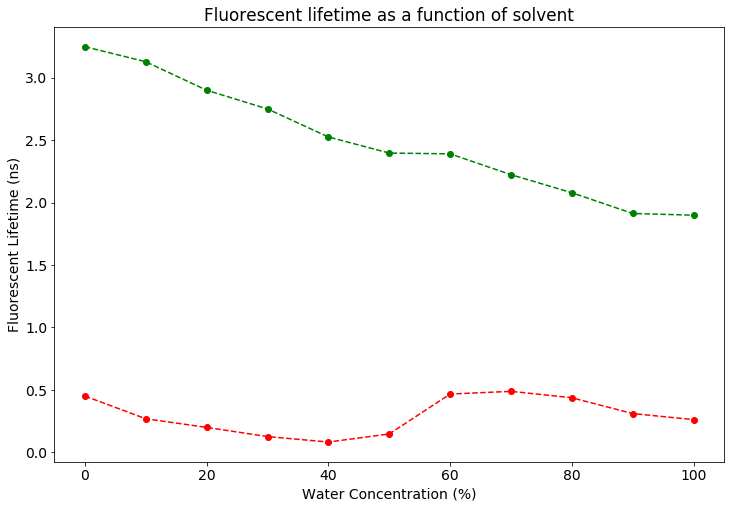

In [52]:
plt.plot(water_percent, lifetime1, 'ro')
plt.plot(water_percent, lifetime2, 'go')
plt.fill_between(water_percent, lifetime2 - lifetime2Err, lifetime2 + lifetime2Err,
                 color='gray', alpha=0.2)
plt.fill_between(water_percent, lifetime1 - lifetime1Err, lifetime1 + lifetime1Err,
                 color='gray', alpha=0.2)
plt.title(r'Fluorescent lifetime as a function of solvent')
plt.xlabel('Water Concentration (%)')
plt.ylabel('Fluorescent Lifetime (ns)')
plt.show()